In [59]:
import pandas
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchmetrics
import numpy as np
from temp_scale import _ECELoss

In [60]:
model = torchvision.models.resnet152(weights=True).cuda()

c:\Users\leomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [61]:
normalize = transforms.Compose(
    [transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])

imagenet = torchvision.datasets.ImageNet(root='data', split='val', transform=normalize)

In [62]:
#validation test split
val_set, test_set = torch.utils.data.random_split(imagenet, [int(len(imagenet)*0.2), int(len(imagenet)*0.8)])
val_loader = torch.utils.data.DataLoader(val_set, batch_size=8, shuffle=False, num_workers=3)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=False, num_workers=3)


In [63]:
def predict(model, loader):
    model.eval()
    predictions = torch.tensor([])
    targets = torch.tensor([])
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x = x.cuda()
            y_hat = model(x)
            predictions = torch.cat((predictions, y_hat.cpu()))
            targets = torch.cat((targets, y.cpu()))
    return predictions, targets

In [292]:
torch.max(torch.softmax(predictions, dim=1), dim=1)

torch.return_types.max(
values=tensor([0.4797, 0.9324, 0.9992,  ..., 0.9707, 0.9694, 0.8596]),
indices=tensor([681, 609,  80,  ...,  28, 209, 440]))

In [64]:
predictions, targets = predict(model, test_loader)

In [65]:
accScore = torchmetrics.functional.accuracy(predictions, targets, task='multiclass', num_classes=1000)
print(f'Accuracy: {accScore.detach()}')

Accuracy: 0.784375011920929


In [66]:
from temp_scale import _ECELoss
print('ECE in test set: %.3f' % _ECELoss()(predictions, targets))
print('NLL in test set: %.3f' % F.cross_entropy(predictions, targets.type(torch.LongTensor)))

ECE in test set: 0.049
NLL in test set: 0.875


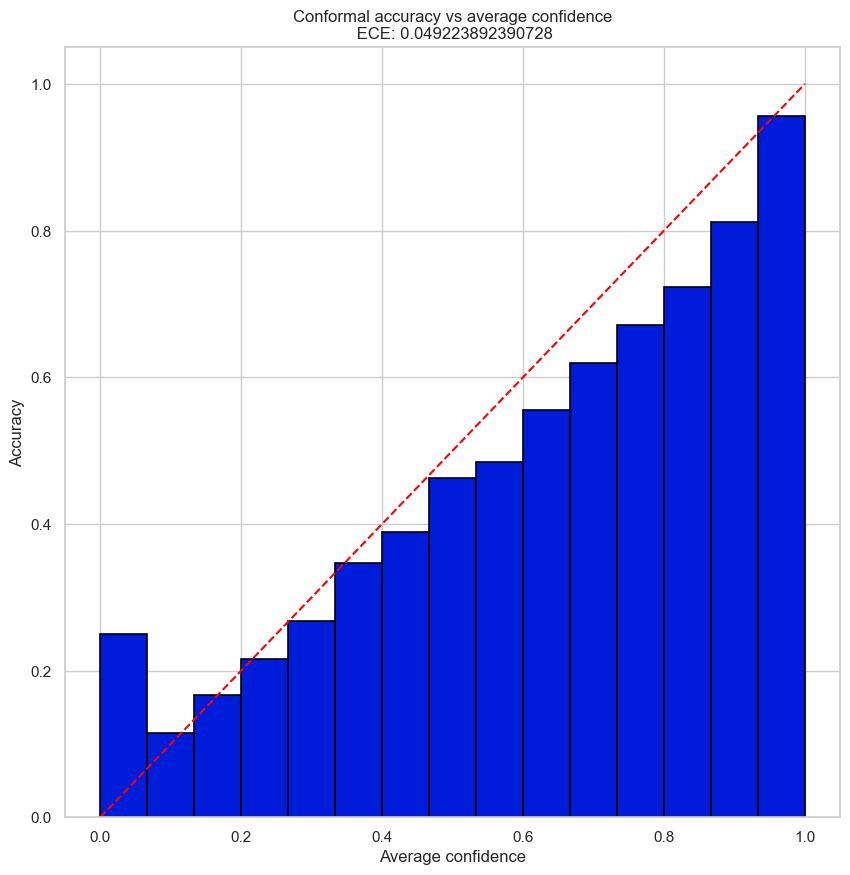

In [320]:
#first we partition the data into 15 bins of equal size
max_pred = torch.max(torch.softmax(predictions, dim=1), dim=1).values.detach().numpy()
predicted_labels = torch.max(predictions, dim=1).indices.detach().numpy()
#0 or 1 for correct or incorrect
correctness = predicted_labels == targets.detach().numpy()

bins = np.linspace(0, 1, 16)
bins = bins[:-1]
binned_conf = np.empty(15, dtype=object)
i=0
for valor in bins:

    binned_conf[i] = max_pred[(max_pred >= valor) & (max_pred < valor + bins[1])]
    i += 1

#now we calculate the acuracy and average confidence for each bin

accuracy = np.empty(15, dtype=object)
avg_conf = np.empty(15, dtype=object)
i=0
for valor in binned_conf:
    if i == 15:
        break
    if len(valor) == 0:
        accuracy[i] = 0
        avg_conf[i] = 0
    else:
        accuracy[i] = correctness[(max_pred >= valor.min()) & (max_pred < valor.max())].mean()
        avg_conf[i] = valor.mean()
    i += 1

#now we plot the results in a bar graph plot the x=y line
import matplotlib.pyplot as plt

ax, fig = plt.subplots(figsize=(10,10))
plt.bar(bins, accuracy, width=bins[1], align='edge', edgecolor='black', color='#001cdb',linewidth=1.2)
plt.plot([0,1], [0,1], color='red', linestyle='dashed')

ece = _ECELoss()(predictions, targets).item()

plt.xlabel('Average confidence')
plt.ylabel('Accuracy')
plt.title(f'Conformal accuracy vs average confidence\n ECE: {ece}')
plt.show()


In [67]:
from temp_scale import ModelWithTemperature

temp_calib_model = ModelWithTemperature(model)

In [68]:
temp_calib_model = temp_calib_model.set_temperature(val_loader)

Before temperature - NLL: 0.883, ECE: 0.053
Optimal temperature: 1.379
After temperature - NLL: 0.870, ECE: 0.039


In [69]:
ts_predictions, ts_targets = predict(temp_calib_model, test_loader)

In [70]:
accScore = torchmetrics.functional.accuracy(ts_predictions, ts_targets, task='multiclass', num_classes=1000)
print(f'Accuracy: {accScore.detach()}')

Accuracy: 0.784375011920929


In [71]:
from temp_scale import _ECELoss
print('ECE in test set: %.3f' % _ECELoss()(ts_predictions, ts_targets))
print('NLL in test set: %.3f' % F.cross_entropy(ts_predictions, ts_targets.type(torch.LongTensor)))

ECE in test set: 0.041
NLL in test set: 0.864


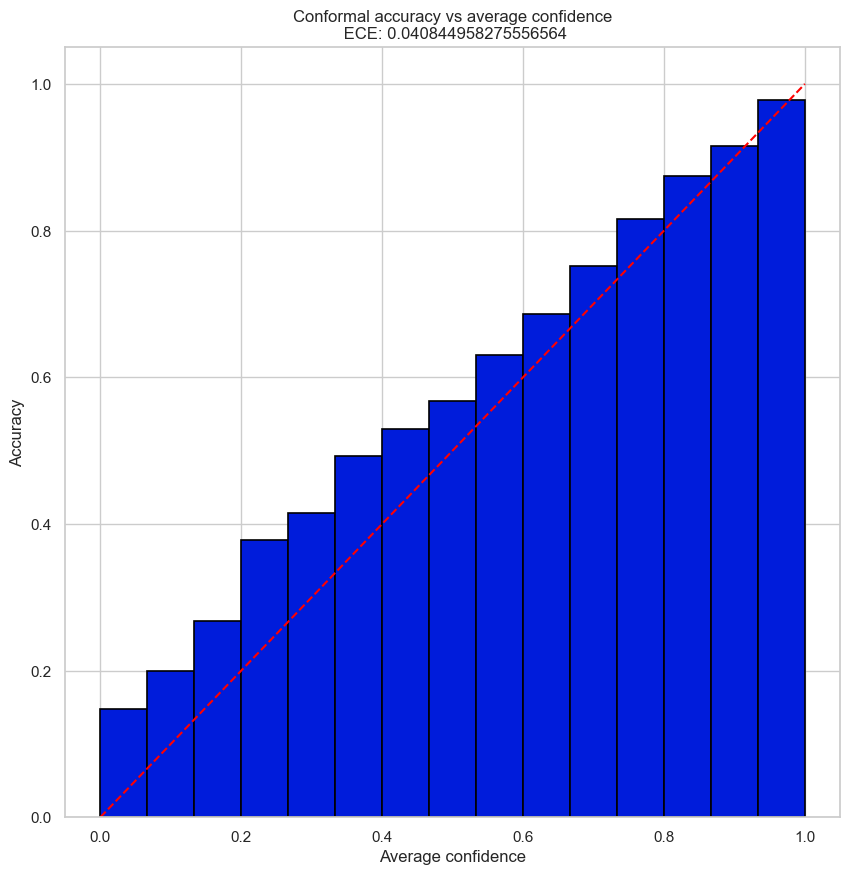

In [321]:
#first we partition the data into 15 bins of equal size
max_pred = torch.max(torch.softmax(ts_predictions, dim=1), dim=1).values.detach().numpy()
predicted_labels = torch.max(ts_predictions, dim=1).indices.detach().numpy()
#0 or 1 for correct or incorrect
correctness = predicted_labels == ts_targets.detach().numpy()

bins = np.linspace(0, 1, 16)
bins = bins[:-1]
binned_conf = np.empty(15, dtype=object)
i=0
for valor in bins:

    binned_conf[i] = max_pred[(max_pred >= valor) & (max_pred < valor + bins[1])]
    i += 1

#now we calculate the acuracy and average confidence for each bin

accuracy = np.empty(15, dtype=object)
avg_conf = np.empty(15, dtype=object)
i=0
for valor in binned_conf:
    if i == 15:
        break
    if len(valor) == 0:
        accuracy[i] = 0
        avg_conf[i] = 0
    else:
        accuracy[i] = correctness[(max_pred >= valor.min()) & (max_pred < valor.max())].mean()
        avg_conf[i] = valor.mean()
    i += 1

#now we plot the results in a bar graph plot the x=y line
import matplotlib.pyplot as plt

ax, fig = plt.subplots(figsize=(10,10))
plt.bar(bins, accuracy, width=bins[1], align='edge', edgecolor='black', color='#001cdb',linewidth=1.2)
plt.plot([0,1], [0,1], color='red', linestyle='dashed')

ece = _ECELoss()(ts_predictions, ts_targets).item()

plt.xlabel('Average confidence')
plt.ylabel('Accuracy')
plt.title(f'Conformal accuracy vs average confidence\n ECE: {ece}')
plt.show()


In [72]:
cal_predictions, cal_targets = predict(temp_calib_model, val_loader)

In [73]:
#softmax for predictions tensor
val_smx = nn.Softmax(dim=1)(predictions)
val_ts_smx = nn.Softmax(dim=1)(ts_predictions)
cal_smx = nn.Softmax(dim=1)(cal_predictions)
#val_ts_smx = nn.Softmax(dim=1)(ts_test_predictions)

In [131]:
def conformal(cal_smx, cal_labels, val_labels, val_smx, size_cal_set):
    cal_scores = 1 - cal_smx[np.arange(size_cal_set), cal_labels]
    alphas = []
    prediction_sets = []
    actual_labels = []
    i = 0

    for i, image in enumerate(val_smx):
        # try alphas until there's only one class in the prediction set
        for alpha in np.arange(0.001, 1, 0.001):
            q_level = np.ceil((size_cal_set + 1) * (1 - alpha)) / size_cal_set
            qhat = np.quantile(cal_scores, q_level, interpolation='higher')

            prediction_set = image >= (1 - qhat)

            if np.sum(prediction_set) == 1:
                prediction_sets.append(prediction_set)
                alphas.append(alpha)
                actual_labels.append(val_labels[i])
                break

            elif alpha >= 0.999:
                prediction_sets.append(prediction_set)
                alphas.append(alpha)
                actual_labels.append(val_labels[i])
                break

    return prediction_sets, alphas, actual_labels


In [132]:
cal_smx_np = cal_smx.cpu().numpy()
cal_labels_np = cal_targets.cpu().numpy()
val_smx_np = val_smx.cpu().numpy()
val_labels_np = targets.cpu().numpy()

#convert labels array to int
cal_labels_np = cal_labels_np.astype(int)
val_labels_np = val_labels_np.astype(int)


prediction_sets, alphas, actual_labels = conformal(cal_smx_np, cal_labels_np, val_labels_np, val_smx_np, len(cal_smx_np))


C:\Users\leomo\AppData\Local\Temp\ipykernel_23948\438766811.py:12: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  qhat = np.quantile(cal_scores, q_level, interpolation='higher')


In [129]:
def evaluate_conformal(prediction_sets, actual_labels):
    prediction_sets = np.array(prediction_sets)
    actual_labels = np.array(actual_labels)
    empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]),actual_labels].mean()
    print(f"The empirical coverage is: {empirical_coverage}")
    return empirical_coverage

def create_fake_logits(alphas):
    fake_logits = 1 - np.array(alphas)
    return fake_logits

40000

In [249]:
conformal_logits = create_fake_logits(alphas)

#first we partition the data into 15 bins of equal size
predicted_labels = torch.argmax(val_smx, dim=1)
#0 or 1 for correct or incorrect
correctness = predicted_labels == targets

bins = np.linspace(0, 1, 16)
bins = bins[:-1]
binned_conf = np.empty(15, dtype=object)
i=0
for valor in bins:

    binned_conf[i] = conformal_logits[(conformal_logits >= valor) & (conformal_logits < valor + bins[1])]
    i += 1

#now we calculate the acuracy and average confidence for each bin

accuracy = np.empty(15, dtype=object)
avg_conf = np.empty(15, dtype=object)
i=0
for valor in binned_conf:
    if i == 15:
        break
    if len(valor) == 0:
        accuracy[i] = 0
        avg_conf[i] = 0
    else:
        accuracy[i] = correctness[(conformal_logits >= valor.min()) & (conformal_logits < valor.max())].to(torch.float).mean()
        avg_conf[i] = valor.mean()
    i += 1




In [250]:
for i in range(15):
    accuracy[i] = np.array(accuracy[i]).item()
    if not accuracy[i] > 0:
        accuracy[i] = 0
    avg_conf[i] = np.array(avg_conf[i]).item() 

In [279]:
#set nan values to 0
error = accuracy - avg_conf
ece_cumulative = 0
for err in error:
    if type(err) == torch.Tensor:
        err = err.cpu().numpy()
    if np.isnan(err):
        err = 0
    ece_cumulative += np.abs(err)

ece = ece_cumulative / 15
print(f"The ECE is: {ece}")

The ECE is: 0.06946919236182003


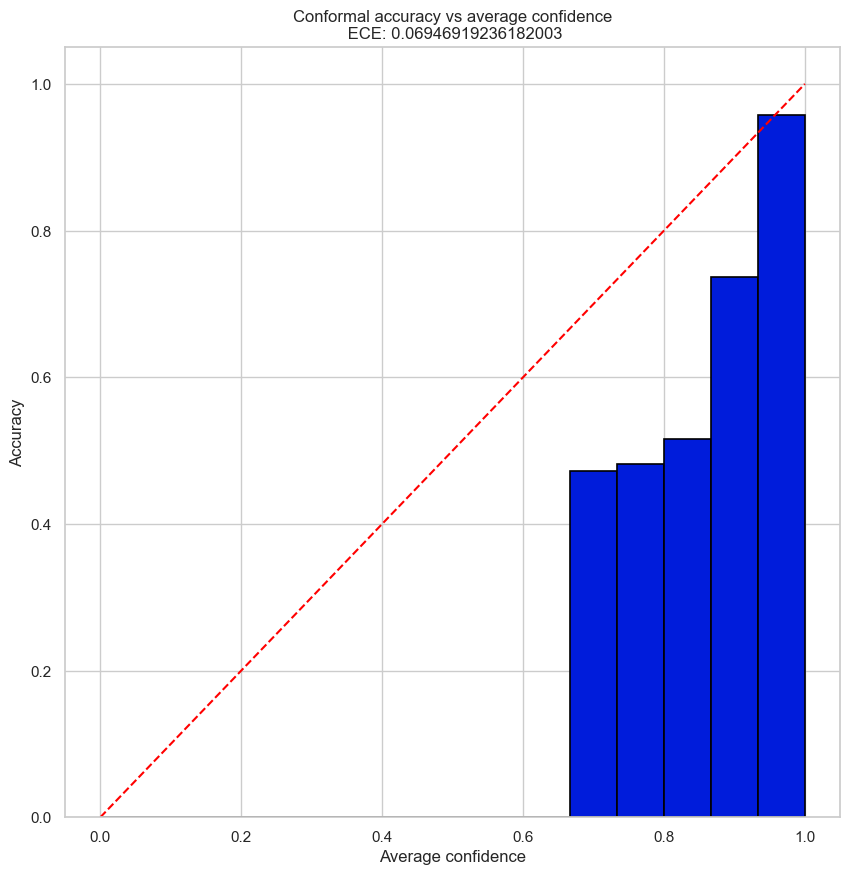

In [280]:
#now we plot the results in a bar graph plot the x=y line
import matplotlib.pyplot as plt

ax, fig = plt.subplots(figsize=(10,10))
plt.bar(bins, accuracy, width=bins[1], align='edge', edgecolor='black', color='#001cdb',linewidth=1.2)
plt.plot([0,1], [0,1], color='red', linestyle='dashed')


plt.xlabel('Average confidence')
plt.ylabel('Accuracy')
plt.title(f'Conformal accuracy vs average confidence\n ECE: {ece}')
plt.show()



In [331]:
#we will generate predictive intervals by adding the softmax probabilities

smx = nn.Softmax(dim=1)(predictions)
smx_ts = nn.Softmax(dim=1)(ts_predictions)

alpha = 0.05
pred_sets = []
for i in range(len(smx)):
    temp = 1
    pred_set =[]
    while temp > alpha:
        temp = smx[i].max()
        pred_set.append(smx[i].argmax())
        smx[i][smx[i].argmax()] = 0
    pred_sets.append(pred_set)

pred_sets_ts = []
for i in range(len(smx_ts)):
    temp = 1
    pred_set =[]
    while temp > alpha:
        temp = smx_ts[i].max()
        pred_set.append(smx_ts[i].argmax())
        smx_ts[i][smx_ts[i].argmax()] = 0
    pred_sets_ts.append(pred_set)

In [335]:
total = 0
correct = 0
for label in targets:
    if label in pred_sets[total]:
        correct += 1
    total += 1

print(f"The coverage is: {correct/total}")
mean_pred_set_size = 0
for pred_set in pred_sets:
    mean_pred_set_size += len(pred_set)
mean_pred_set_size = mean_pred_set_size / len(pred_sets)
print(f"The mean predictive set size is: {mean_pred_set_size}")


The coverage is: 0.9246
The mean predictive set size is: 2.740525


In [334]:
total = 0
correct = 0
for label in ts_targets:
    if label in pred_sets_ts[total]:
        correct += 1
    total += 1

print(f"The coverage is: {correct/total}")
mean_pred_set_size = 0
for pred_set in pred_sets:
    mean_pred_set_size += len(pred_set)
mean_pred_set_size = mean_pred_set_size / len(pred_sets)
print(f"The mean predictive set size is: {mean_pred_set_size}")

The coverage is: 0.92855
The mean predictive set size is: 2.740525


In [342]:
cal_smx = nn.Softmax(dim=1)(cal_predictions).numpy()
#cal_targets = cal_targets.numpy()
cal_targets = cal_targets.astype(int)

val_smx = nn.Softmax(dim=1)(predictions).numpy()
val_targets = targets.numpy().astype(int)

cal_scores = 1 - cal_smx[np.arange(len(cal_smx)), cal_targets]

q_level = np.ceil((len(cal_smx) + 1) * (1 - alpha))/len(cal_smx)
q_hat = np.quantile(cal_scores, q_level, interpolation='higher')

pred_sets = val_smx >= (1 - q_hat)


C:\Users\leomo\AppData\Local\Temp\ipykernel_23948\3249552823.py:11: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  q_hat = np.quantile(cal_scores, q_level, interpolation='higher')


In [349]:
empirical_coverage = pred_sets[np.arange(pred_sets.shape[0]),val_targets].mean()
print(f"The empirical coverage is: {empirical_coverage}")

#now we calculate the average size of the predictive sets
mean_pred_set_size = 0
for pred_set in pred_sets:
    for i in pred_set:
        mean_pred_set_size += i
mean_pred_set_size = mean_pred_set_size / len(pred_sets)
print(f"The mean predictive set size is: {mean_pred_set_size}")

The empirical coverage is: 0.934675
The mean predictive set size is: 2.684175
